In [1]:
using PyCall, PyPlot
using Distributions
println(PyCall.pyversion)      # python のバージョンを表示
println(PyCall.pyprogramname)  # python の絶対パス
println(PyCall.libpython)      # python lib のパス
println(PyCall.conda)          # Conda Python をつかっているか true, false
@pyimport numpy

3.5.4
/Users/MiniBell/anaconda3/envs/py35con/bin/python
/Users/MiniBell/anaconda3/envs/py35con/lib/libpython3.5m.dylib
false


# ガウス過程回帰 Gaussian process regression

## ガウス過程 Gaussian process

$\textbf{w}$と$\phi(\textbf{x})$の内積で表される$y = \textbf{w}^T\phi(\textbf{x})$は、ベクトル$\textbf{x}$を入力として$y$を計算する。
これをN組集めた連立方程式  

$$
\textbf{y} = \Phi \textbf{w}
$$　　

の係数のベクトル$\textbf{w}$が平均0, 分散$\alpha^{-1}\textbf{I}$の（多次元）ガウス分布に従うとき、つまり  

$$
p(\textbf{w}) = N(\textbf{w} | \textbf{0}, \alpha^{-1} \textbf{I}) 
$$　　

となるとき、$\textbf{y} = \Phi \textbf{w}$もまたガウス分布に従い、平均0, 分散  

$$
<\textbf{y}\textbf{y}^T> = <\Phi \textbf{w}\Phi \textbf{w}^T> = \Phi <\textbf{w}\textbf{w}^T>\Phi^T=\alpha^{-1}\Phi\Phi^T 
$$

となる。この関係は入力$\textbf{x}$と無関係なので、どんな入力に対しても成り立つ。  
これを$\textbf{y}=(y_1, y_2, \cdots, y_N )$がガウス過程に従う、と呼ぶ。ここで  

$$
\textbf{K} = \alpha^{-1}\Phi\Phi^T
$$

と定義する。
$\textbf{K}$は入力の次元数$N$の正方行列であり、各要素は  

$$
k(\textbf{x}, \textbf{x}') = \alpha^{-1} \phi(\textbf{x})^T\phi(\textbf{x}')
$$

のように、（非線形の）特徴空間への写像$\phi(\textbf{x})$に基づくカーネル関数となる。　　

実際の観測値にはノイズが乗っているため、$\epsilon = N(0, \beta^{-1}\textbf{I})$なる雑音を付加する。  
簡単のため$f =\textbf{w}^T\phi(\textbf{x})$とおくと
$$
y_n  = f(\textbf{x}_n) + \epsilon \\
p(y_n|f) = N(t|f, 1/\beta \textbf{I} ) \\
p(\textbf{y} | \textbf{f}) = N(\textbf{f}, 1/\beta\textbf{I})
$$  　

となる。いま、$\textbf{X}$が観測されたときの$\textbf{y}$の分布に興味があるので、$\textbf{f}$で周辺化すると

$$
p(\textbf{y}|\textbf{X}) = \int{p(\textbf{y}, \textbf{f}| \textbf{X})}d\textbf{f} \\
=\int{p(\textbf{y}|\textbf{f})p(\textbf{f}|\textbf{X})}d\textbf{f}  \\
=\int{N(\textbf{y}|\textbf{f}, 1/\beta \textbf{I}) N(\textbf{f}| \textbf{μ}, \textbf{K}) }d\textbf{f}
$$  

となり、２つの独立したガウス分布の畳み込みとなる。　　

２つの独立したガウス分布を畳み込んだ結果はガウス分布（共分散は２つの共分散の和）となるため、以下の正規分布が得られる。
$$
p(\textbf{y}|\textbf{X}) = N(\textbf{μ}, \textbf{K} + 1/\beta \textbf{I})
$$

$\textbf{C}_N = \textbf{K} + 1/\beta \textbf{I}$とする。$\textbf{C}_N$の各要素は、クロネッカーのデルタを使って 以下のように表せる。

$$
k(\textbf{x}_m, \textbf{x}_n) = \alpha^{-1} \phi(\textbf{x}_m)^T\phi(\textbf{x}_n) + 1/\beta + \delta(n, m)
$$

### クロネッカーのデルタ Kronecker's delta
$i=j$のときだけ$\delta_{i,j}=1$、それ以外は$\delta_{i,j}=0$となる関数。  
行列の対角成分にんだけ処理をしたい場合に使う。正方行列を使っても同じことができる。

In [2]:
function kronecker(i, j)
    if i == j
        return 1
    else
        return 0
    end
end

kronecker (generic function with 1 method)

### カーネル関数 Kernel function
二つのベクトルの”近さ”をスカラで返す関数。 

下記はガウシアンカーネルを実装。RBFとも呼ばれる。カーネル関数$k()$
$$
    k(x_1, x_2) = a^2 \exp\{-\frac{1}{2}(x_1 - x_2)\Lambda(x_1-x_2)\}  \\
    \Lambda = Diag(\sigma_0^2, \sigma_1^2, ... , \sigma_n^2)^{-1} \\
$$
  
この書き方もよく見るけど、これだと入力ベクトルの各要素ごとの分散を別々に扱えない気がする。
$$
    k(x_1, x_2) = a^2 \exp(-\frac{1}{2}\frac{||x_1 - x_2||^2}{\sigma^2} )  \\
$$

In [3]:
function kernel(x1, x2, θ_list)
    # 任意の字数のベクトルの写像
    # NOTE: theta= [σf, σl0, σl1,...]
    σf      = θ_list[1]
    # σl_list = θ_list[2:end]
    # Λ    = inv(Diagonal(σl_list))^2
    n = size(x1)[1]
    Λ = eye(n) * θ_list[2]
    
    coef = ((x1 - x2)' * Λ * (x1 - x2))[1] # Get scalar from 1-element Array
    return (σf^2) * exp(-1/2.0 * coef)
end

kernel (generic function with 1 method)

### グラム行列K Gram matrix
ある正方行列$A$に対して$AA^T$を考えると、$AA^T$はグラム行列と呼ぶ。
グラム行列は半正定値である。（$AA^T >= 0$）  
機械学習やデータサイエンスの分野では、要素$i,j$が$k(x_i, x_j)$となる行列$K$をグラム行列と呼ぶ。  
ただし、カーネル関数が正定値カーネルでない場合は（半）正定値を満たさない。（$K >= 0$とは限らない）
逆に、カーネル関数が正定値カーネルの場合、$K$は半正定が保証される。（ガウシアンカーネルは正定値カーネル）

余談：  
正定値カーネルではない場合は、$K$が正定値を満たすように変換するのがよいとされる。

- $K = K + \lambda I$とする。つまり定数倍の単位行列を足す。
- $K = PDP^T$と固有値分解し、$D$の負の固有値を0に交換した$D'$をつかって、$K'=PD'P^T$とする

In [4]:
# 多次元対応
function gram_matrix(x1, x2, θ_list)
    n = size(x1)[2] # データ数
    m = size(x2)[2] # データ数
    K = zeros(n, m) 

    for i=1:n
        for j=1:m
            K[i, j] = kernel(x1[:, i], x2[:, j], θ_list) 
        end
    end
    return K
end

gram_matrix (generic function with 1 method)

### ガウス過程回帰モデル
$y=f(\textbf{x})$の$f$がガウス過程から生成されているとする。  

$y$と$\textbf{x}$の$N$個の組$\textbf{y}=(y_1, y_2, \cdots, y_N )$、$\textbf{X}=(\textbf{x}_1, \textbf{x}_2, \cdots, \textbf{x}_N )$から$\textbf{C}_N$が決まる。

ある$f(\textbf{x})$がどのような$\textbf{y}$を出力するかを予想（回帰）する。
これを$N+1$個目のペアとしても、やはり$\textbf{y}'=(y_1, y_2, \cdots, y_N, y_{N+1})$はガウス過程に従う。　　  
同時分布は

$$
p(\textbf{y}') = N( 0, 
\begin{pmatrix}  
\textbf{C}_N & \textbf{k} \\
\textbf{k}^T & k
\end{pmatrix}
)
$$

求めたい条件つき分布は$p(y_{N+1} | \textbf{y})$なので、ガウス分布の条件付き分布より

$$
p(y_{N+1} | \textbf{y}) = N(\textbf{k}^T \textbf{C}_N \textbf{y}, k-\textbf{k}^T \textbf{C}_N^{-1})
$$

N個のペアをデータと考えて$D$とすると、$D$と$\textbf{x}_{N+1}$が観測されるという条件付き分布ということで、以下のように表記できる。

$$
p(y_{N+1} | \textbf{x}_{N+1}, D) = N(\textbf{k}^T \textbf{C}_N \textbf{y}, k-\textbf{k}^T \textbf{C}_N^{-1})
$$


In [5]:
function regression(mx1, mx2, x_obs, y_obs, b, th)
    # 共分散行列の計算
    K = gram_matrix(x_obs, x_obs, th)
    n = size(y_obs)[1]
    C_N = K + eye(n)/b

    n_x2, n_x1 = size(mx1)

    # 平均値の計算
    m_mesh = copy(mx1) * 0

    for i = 1:n_x1
        for j = 1:n_x2
            x = [mx1[j, i], mx2[j, i]]
            k = [kernel(x_obs[:, l], x, th) for l =1:length(y_obs)]
            m =   k' *  inv(C_N)  * y_obs
            m_mesh[j, i] = m
        end
    end

    # 分散の計算
    Sig2_mesh = copy(mx1)*0
    for i = 1:n_x1
        for j = 1:n_x2
            x = [mx1[j, i], mx2[j, i]]
            k = [kernel(x_obs[:, l], x, th) for l =1:length(y_obs)]
            c = kernel(x, x, th) + 1/b
            Sig2_mesh[j, i] = c - k' * inv(C_N) * k
        end
    end
    
    return m_mesh, Sig2_mesh
end

regression (generic function with 1 method)

### 対数尤度
$D$次元ガウス分布$N(x|\mu, \Sigma)$の対数表示は
$$
\ln{N(x|\mu, \Sigma)}=-\frac{1}{2}\{  (x-\mu)^T \Sigma^{-1} (x-\mu) + \ln{\det{\Sigma}} + D\ln{2\pi}    \}
$$

ハイパーパラメータは、$\ln{p(\boldsymbol{t} | \boldsymbol{\theta})}$を最大にするようにして決定する。
これもガウス分布なので同様に変形できる。
$$
\ln{p(\boldsymbol{t} | \boldsymbol{\theta})}=-\frac{1}{2}\{\boldsymbol{t}^T \textbf{C}_N^{-1} \boldsymbol{t} + \ln{\det{\textbf{C}_N}} + D\ln{2\pi}    \} \\
C_N = K + \beta^{-1}I
$$

もし$K$が半正定値行列出ない場合、$\det{K}$が負となるため対数が計算できない。

In [6]:
function log_likelihood(x, y, β, θ_list)
    t = y
    n = size(x)[2] # size of data
    K = gram_matrix(x, x, θ_list)
    C = K + 1.0 / β * eye(n)
    
    tCt = t' * inv(C) * t
    logdetC = logdet(C) 
    return  -1/2.0 * tCt - 1/2.0 * logdetC - n/2.0 * log(2*pi)
end

log_likelihood (generic function with 1 method)

### 共分散行列$C_N$の偏微分
勾配法で超パラメタをきめるときの準備

In [7]:
function deriv2(x1, x2, theta)

    # パラメータaでの微分
    delta_0 = 2 * theta[1] * exp(-0.5* (norm(x1-x2) / theta[2])^2 ) 

    # パラメータbでの微分
    delta_1 = (theta[1]^2) / (theta[2]^3) *( norm(x1-x2)^2) *  exp(-0.5* (norm(x1-x2) / theta[2])^2 ) 
    
    return [delta_0, delta_1]
end

deriv2 (generic function with 1 method)

## ２次元データへのガウス過程の適用
適当に作ったデータにガウス過程を適用する。

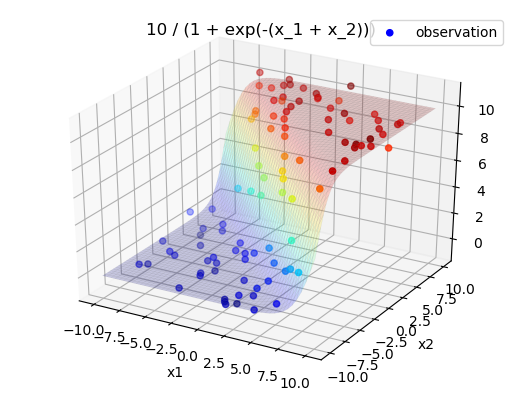

In [42]:
function fx(x1, x2)
    # z = x1.^2 + x2.^2 + 10*cos.(x2) # Tekitou
    # z = 10.0 * 1.0 ./ (1 + exp.(-x1)) # Sigmoid
    z = 10.0 * 1.0 ./ (1 + exp.(-(x1+x2))) # Sigmoid
    return z
end

n = 100
b = 20 

x_obs = rand(n)*50
sige2 = 0.4

x1_obs = rand(n) * 20 - 10 
x2_obs = rand(n) * 20 - 10 

# DEBUG: 
# x1_obs = 0 .* x1_obs 
#  ----

x_obs = reshape([x1_obs; x2_obs], (length(x1_obs), 2))'

# create observation toy data
y_obs = fx(x1_obs, x2_obs) .+ rand(Normal(0, sige2), n); # Norm(x1_obs | 0, σ^2)

# create ground truth
mx1,mx2 = numpy.meshgrid(linspace(-10,10,50), linspace(-10,10,50));
# mx1,mx2 = numpy.meshgrid(linspace(0,0,1), linspace(-10,10,50));

my = fx(mx1,mx2)

# viz
surf(mx1, mx2, my, cmap=ColorMap("jet"), alpha=0.2, edgecolor="gray", linewidth=0.2);
scatter3D(x1_obs, x2_obs, y_obs', "o", c=y_obs, cmap="jet", linewidth=1.0, label="observation")
xlabel("x1")
ylabel("x2")
title("10 / (1 + exp(-(x_1 + x_2)))")
legend();

### ガウス過程の超パラメタをMCMCで推定
そのまえにMCMCで非線形関数の最大値を求める練習をしてみる。
メトロポリス・ヘイスティング法を実装[2]した

In [26]:
function estimate_params_gradient(x_obs, y_obs, max_iter = 500)
    # learning rate
    alpha = 0.0001
    b = 0.04

    param =  [2.0, 1.0]
    params = []
    grads1 = []
    grads2 = []
    log_likelihood_hist = []

    params = []
    push!(params, copy(param))

    eps =  0.001 # stop condition

    # 更新前の値
    prev_log_likelihood = log_likelihood(x_obs, y_obs, b, param)
    # println(prev_log_likelihood)
    prev_param = copy(param)

    for it =1:max_iter

        #  fit
        K = gram_matrix(x_obs, x_obs, param)
        n = size(y_obs)[1]
        C_N = K + eye(n)/b

        x1 = copy(x_obs)
        x2 = copy(x_obs)
        n = size(x1)[2] # num of data
        m = size(x2)[2] # num of data
        d1_C_N = zeros(n, m)
        d2_C_N = zeros(n, m)

        for i=1:n
            for j=1:m
                # println(deriv(x1[i], x2[j], theta)[1])
                d1_C_N[i, j] = deriv2(x1[:, i], x2[:, j], param)[1]
                d2_C_N[i, j] = deriv2(x1[:, i], x2[:, j], param)[2]
            end
        end

        d1_evidence = -0.5 * trace( inv(C_N) * d1_C_N ) + 0.5 * y_obs' * inv(C_N) * d1_C_N * inv(C_N) * y_obs
        d2_evidence = -0.5 * trace( inv(C_N) * d2_C_N ) + 0.5 * y_obs' * inv(C_N) * d2_C_N * inv(C_N) * y_obs

        # 値の更新
        param[1]  = param[1] + alpha * d1_evidence[1] # because d1_evidence is Array type
        param[2]  = param[2] + alpha * d2_evidence[1] # because d2_evidence is Array type
        log_likelihood_var = log_likelihood(x_obs, y_obs, b, param)

        # ログ
        push!(grads1, d1_evidence)
        push!(grads2, d2_evidence)
        push!(log_likelihood_hist, log_likelihood_var)
        push!(params, copy(param))

        # 前回値との比較
        diff_var = abs(log_likelihood_var - prev_log_likelihood)
        if diff_var < eps
            println("break!!")
            print(it)
            println(" iter")

            break
        end

        # 値を保存
        prev_param = copy(param)
        prev_log_likelihood = log_likelihood_var

    end
    best_param = copy(param)
    # println(best_param)
    
    return best_param
end

estimate_params_gradient (generic function with 2 methods)

In [25]:
function estimate_params_mcmc(x_obs, y_obs, n = 5000)
    # println(n)
    param0 = [1.0, 1.0, 1.0] # パラメータの初期値 [b, theta1, theta2]

    bound = [1e-3 1e3  # b
             1e-3 1e3  # theta1
             1e-3 1e3] # theta2 下限上限

    logbound = log.(bound)

    s = (logbound[:,2] - logbound[:,1])/10.0
    n_param = length(param0)
    logparam0 = log.(param0)

    p0 = log_likelihood(x_obs, y_obs, param0[1], param0[2:end])

    lis_logparam = []
    lis_p = []

    for i = 1:n
        idou = rand(Normal(0,s[1]),n_param) # 移動する距離
        is_logparam_small = (logparam0 + idou) .< logbound[:, 1]
        is_logparam_big = (logparam0 + idou) .> logbound[:, 2]
        is_logparam_outside = (is_logparam_small .& is_logparam_big) 

        # 枠内になるまでサンプリングを繰り返す
        while(numpy.any(is_logparam_outside))
            println("samping again")
            idou = rand(Normal(0,s[1]),n_param)[is_logparam_outside] # 移動する距離
            is_logparam_small = (logparam0 + idou) .< logbound[:, 1]
            is_logparam_big = (logparam0 + idou) .> logbound[:, 2]
            is_logparam_outside = (is_logparam_small .& is_logparam_big) 
        end

        logparam1 = logparam0 + idou
        param1 = exp.(logparam1)
        p1 = log_likelihood(x_obs, y_obs, param1[1], param1[2:end])
        r = exp(p1-p0)

        # 比率は1より高い場合は常に移動するが、低い場合は確率で移動する
        if (r > 1.0) | (r > rand())
            logparam0 = logparam1 # 現在の位置を新しい位置に移動する
            p0 = p1
            push!(lis_logparam, logparam0) # 新しい位置を格納
            push!(lis_p,  p0) # 新しい確率を格納
        end
    end

    # 最大の場所
    if (length(lis_p) == 0)
        println("err! no elements!")
    else
        # println(lis_p)
        maxvar, ind =findmax(lis_p)

        lp1 = [e[1] for e in lis_logparam]
        lp2 = [e[2] for e in lis_logparam]
        lp3 = [e[3] for e in lis_logparam]
        lp1[ind]
        p1max = exp(lp1[ind])
        p2max = exp(lp2[ind])
        p3max = exp(lp3[ind])
        # println(p1max, ", ", p2max, ", ", p3max)
    end

    # println(p1max,", ",  p2max, ", ",  p3max)
    return p1max, p2max, p3max
end   

estimate_params_mcmc (generic function with 2 methods)

In [38]:
# Estimate parameters using MCMC
p1max, p2max, p3max = estimate_params_mcmc(x_obs, y_obs, 500);
b_mcmc = p1max
th_mcmc = [p2max, p3max]

# Estimate parameters using grad
p2max, p3max = estimate_params_gradient(x_obs, y_obs, 500);
b_grad = 3.0 
th_grad = [p2max, p3max]

# Random parameters 
b_rand = 3.0 
th_rand = [10, 1]# [rand()*10, rand()*10]　

m_mcmc, sig2_mcmc = regression(mx1, mx2, x_obs, y_obs, b_mcmc, th_mcmc)
m_grad, sig2_grad      = regression(mx1, mx2, x_obs, y_obs, b_grad, th_grad)
m_rand, sig2_rand   = regression(mx1, mx2, x_obs, y_obs, b_rand, th_rand);

break!!
147 iter


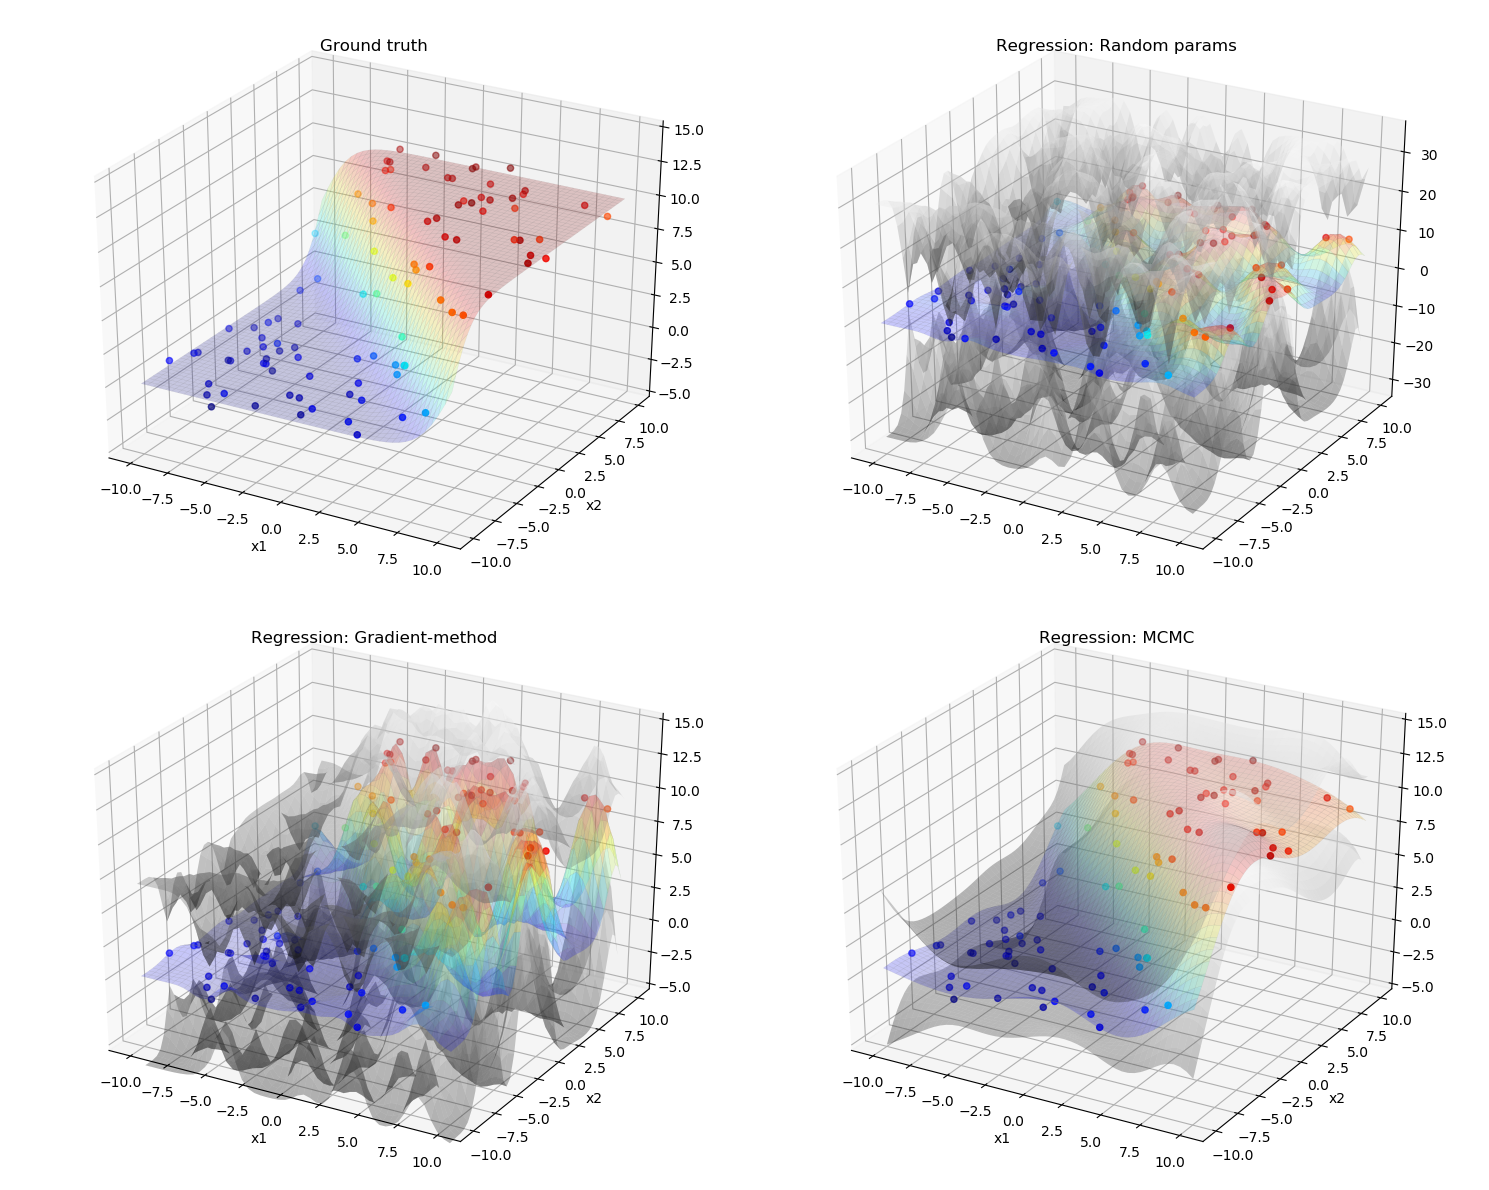

In [39]:
figure(figsize=(15,12))

subplot(221, projection="3d")
surf(mx1, mx2, my, cmap=ColorMap("jet"), alpha=0.2, edgecolor="gray", linewidth=0.2);
scatter3D(x1_obs, x2_obs, y_obs', "o", c=y_obs, cmap="jet", linewidth=1.0, label="observation")
xlabel("x1")
ylabel("x2")
zlim([-5, 15])
title("Ground truth")

subplot(222, projection="3d")
surf(mx1, mx2, m_rand, cmap=ColorMap("jet"), alpha=0.2, edgecolor="gray", linewidth=0.2)
surf(mx1, mx2, m_rand  - 3*sqrt.(sig2_rand), cmap=ColorMap("gray"), alpha=0.3) # , edgecolor="gray", linewidth=0.2)
surf(mx1, mx2, m_rand + 3*sqrt.(sig2_rand), cmap=ColorMap("gray"), alpha=0.3) # , edgecolor="gray", linewidth=0.2)
scatter3D(x1_obs, x2_obs, y_obs', "o", c=y_obs, cmap="jet", linewidth=1.0, label="observation")
title("Regression: Random params");

subplot(223, projection="3d")
surf(mx1, mx2, m_grad, cmap=ColorMap("jet"), alpha=0.2, edgecolor="gray", linewidth=0.2)
surf(mx1, mx2, m_grad  - 3*sqrt.(sig2_grad), cmap=ColorMap("gray"), alpha=0.3) # , edgecolor="gray", linewidth=0.2)
surf(mx1, mx2, m_grad + 3*sqrt.(sig2_grad), cmap=ColorMap("gray"), alpha=0.3) # , edgecolor="gray", linewidth=0.2)
scatter3D(x1_obs, x2_obs, y_obs', "o", c=y_obs, cmap="jet", linewidth=1.0, label="observation")
xlabel("x1")
ylabel("x2")
zlim([-5, 15])
tight_layout()
title("Regression: Gradient-method");

subplot(224, projection="3d")
surf(mx1, mx2, m_mcmc, cmap=ColorMap("jet"), alpha=0.2, edgecolor="gray", linewidth=0.2)
surf(mx1, mx2, m_mcmc- 3*sqrt.(sig2_mcmc), cmap=ColorMap("gray"), alpha=0.3) # , edgecolor="gray", linewidth=0.2)
surf(mx1, mx2, m_mcmc + 3*sqrt.(sig2_mcmc), cmap=ColorMap("gray"), alpha=0.3) # , edgecolor="gray", linewidth=0.2)
scatter3D(x1_obs, x2_obs, y_obs', "o", c=y_obs, cmap="jet", linewidth=1.0, label="observation")
xlabel("x1")
ylabel("x2")
zlim([-5, 15])
tight_layout()
title("Regression: MCMC");

MCMC以外はまともに回帰できていないことがわかる。

# 参考文献
[0] PRML  
[1] ベイズ推論にとる機械学習入門  
[2] pythonでガウス過程を実装する。パラメータの調整はマルコフ連鎖モンテカルロ法（MCMC）を使うhttps://qiita.com/phyblas/items/d756803ec932ab621c56  
[3] 確率過程の基礎  